# Credit Card Fraud Dataset
## About The Dataset
This dataset is very popular for all kinds of machine learning cyber security techniques. This dataset contains simulated credit card transactions with legitimate and fraudulent transactions. It covers credit cards of over 1000 customers transactions with a pool of 800 merchants.

## Key Details:
Number of Instances: The dataset consists of 1.3 million instances.
Number of Features: There are 23 different features that help describe the inidividual transactions making them all unique.
Target Variable: The target variable in the dataset is is_fraud, representing the if the transaction actually was fraudulent.

### Data Types:
The features include both numerical and categorical variables.
They cover a wide range of aspects such as transaction time, credit card number, zip code of the transaction, merchant details and more.

### Applications:
The Credit Card Fraud Dataset is widely used in the machine learning community for:
- Cyber Security

## Binary Modeling: Predicting likelyhood that a transaction is Fraudulent
Feature Engineering: Developing and testing new techniques to handle numerical and categorical data.
Predictive Analytics: Analyzing previous transactions and predicting if a transaction is fraudulent.

# STEP 1
Importing all necessary libraries and setup

In [1]:
# Standard Libraries
import os
import time
import logging

# Data Handling & Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Functions
from scipy.stats import skew

# Scikit-learn Libraries for Model Building & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures

# AWS & SageMaker Libraries for Model Training and Deployment
import boto3
import sagemaker
from sagemaker import Session, get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.linear_learner import LinearLearner  # SageMaker's built-in Linear Learner algorithm
from sagemaker.inputs import TrainingInput
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Additional Libraries
from botocore.exceptions import ClientError
from typing import Any, List, Union

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# File Path and Original Target Column
file_path = "fraudTrain.csv"
original_target_col = "is_fraud"

print("Imported Successfully!")

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/25/25 21:15:04] INFO     Found credentials from IAM Role:                                   ]8;id=648921;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=850738;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Imported Successfully!


# STEP 2
Load the data and preview the head, the shape and the description of the data

In [3]:
def load_data(filepath):
    """
    Load the CSV file into a pandas DataFrame.
    """
    df = pd.read_csv(filepath)
    return df

df = load_data(file_path)

print("Data Loaded Successfully!\n")

# Examine the first few rows
print(df.head())
df.info()

Data Loaded Successfully!

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Rile

# STEP 3: Check / Drop Columns

### 3A

In general it is very important to make sure that you data does not have a column with mass amounts of missing data. This will cause massive issues in your dataset if you were to do a data anlysis on the data there would be a massive imbalance causing lots of errors and would also make it impossible to do any type of machine learning on the dataset. 

I chose 15% for my specific dataset because of the high need for security, this ensures that  no column can cause any future errors when running a machine learning model and on top of that also you cannot replace that data with simulated values for almost every situation

In [4]:
def drop_high_missing_columns(dataframe, threshold=0.15):
    """
    Drop columns from the DataFrame where the fraction of missing values exceeds the specified threshold.

    This function calculates the percentage of missing values in each column and removes
    those columns where the fraction of missing values is greater than the threshold. 
    This helps reduce noise and potential bias when features with too many missing values
    might negatively impact the model's performance.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        threshold (float): The maximum allowable fraction of missing values for a column.
                           Columns exceeding this threshold will be dropped (default is 0.3).

    Returns:
        pd.DataFrame: A DataFrame with columns removed that have more than the allowed missing values.
    """
    # Identify columns where the proportion of missing values exceeds the threshold.
    cols_to_drop = dataframe.columns[dataframe.isnull().mean() > threshold]
    
    # Print out the columns that will be dropped for transparency.
    print(f"Dropping columns with more than {threshold*100:.0f}% missing values: {list(cols_to_drop)}")
    
    # Return a new DataFrame with the identified columns removed.
    return dataframe.drop(columns=cols_to_drop)


# Apply the function to the DataFrame to remove columns with too many missing values.
df = drop_high_missing_columns(df)

Dropping columns with more than 15% missing values: []


### 3B

Now that I have dropped all columns with too much missing data I will now drop the columns that I don't belive will be necessary including:
- Birthday - irrelevant to determe whether a transaction is fraudulent
- Unnamed - this was the id of the transaction and has no relevance for the machine learning model
- First/Last name - people may have identical names and it could create a bias flagging all people with the same name as fraudulent transactions if there was fraud under their name
- City Pop / Street / Lat / Long - All of these refer to the location of the individual's home which should not have any impact on whether a transaction is fraudulent
- Merch Long / Merch Long -  All of these refer to the exact location of the merchant which should not have an impact of identifying fraudulent transactions
- Unix Time - Conisdering we already have a column taking time into account it would be unneccessary to have a repeat column

In [5]:
def drop_columns(dataframe):
    """
    Drop columns that I have deemed to be irrelavnt.
    """
    cols_to_drop = ["dob", "Unnamed: 0", "first", "last", "gender",
                    "street", "city", "lat", "long", "city_pop", "merch_lat", "merch_long", "unix_time", "state", "job"]
    for i in cols_to_drop:
        dataframe.drop(columns=i, inplace=True)
    return dataframe

df = drop_columns(df)

print('Columns Dropped Successfully!')

Columns Dropped Successfully!


# STEP 4: Remove Rows Missing the Target Variable

### 4A
I dropped all columns within this dataset that had missing target values, this is important because if the target value is missing we are unable to fill in the fill result with precision which could negatively affect the accuracy of a machine learning model if you were to train it off of the dataset.

In [6]:
def drop_missing_target(dataframe, target_column):
    """
    Drop rows from the DataFrame where the target variable is missing.

    This function checks if the target column exists in the DataFrame.
    If it does, rows with missing values in the target column are removed.
    This is crucial because missing target values can cause issues during model training,
    leading to inaccurate or biased predictions.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to process.
        target_column (str): The name of the target variable column.

    Returns:
        pd.DataFrame: A DataFrame with rows removed where the target variable is missing.
    """
    # Check if the target column exists in the DataFrame.
    if target_column not in dataframe.columns:
        print(f"Target column '{target_column}' not found.")
        return dataframe

    # Record the number of rows before dropping missing target values.
    before = len(dataframe)
    
    # Drop rows where the target column has missing values.
    dataframe = dataframe.dropna(subset=[target_column])
    
    # Record the number of rows after the operation.
    after = len(dataframe)
    
    # Inform the user about how many rows were dropped.
    print(f"Dropped {before - after} rows with missing '{target_column}'.")
    
    return dataframe

# Apply the function to drop rows with missing values in the target column.
df = drop_missing_target(df, original_target_col)

Dropped 0 rows with missing 'is_fraud'.


### 4B
I dropped all rows within this dataset that had missing values, this is important because if there are any missing values in a row and we can't fill it in without the exact information that could completely change the actual information about the transaction which could decrease the accuracy of the machine learning model and cost the KCU money

In [7]:
# Drop all rows with missing values from the dataset
df.dropna()

,trans_date_trans_time,cc_num,merchant,category,amt,zip,trans_num,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,28654,0b242abb623afc578575680df30655b9,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,99160,1f76529f8574734946361c461b024d99,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,83252,a1a22d70485983eac12b5b88dad1cf95,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,59632,6b849c168bdad6f867558c3793159a81,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,24433,a41d7549acf90789359a9aa5346dcb46,0
...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,84735,440b587732da4dc1a6395aba5fb41669,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,21790,278000d2e0d2277d1de2f890067dcc0a,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,88325,483f52fe67fabef353d552c1e662974c,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,57756,d667cdcbadaaed3da3f4020e83591c83,0


# STEP 5: Fill Remaining Missing Values

In general it is very important to fill in remianing values to make sure that the data available in consistend and that it is not missing any data. In this specific case I dediced that it was best to to not fill any values that are missing, this is because in every transaction, each case is completely unique and not dependant on any other transaction. Therefore it would be unfair and harmful to a machine learning model to fill in the information rather than just drop that case especially when you have so much data

------------

I have provided the code for this although I do not use it for my assignment

In [8]:
def fill_missing_values(dataframe):
    """
    Fill missing values in the DataFrame for both numerical and categorical columns.

    For numerical columns, missing values are replaced with the median. The median is 
    chosen because it is less sensitive to outliers compared to the mean. For categorical 
    columns, missing values are replaced with the string "Missing" to explicitly denote 
    that data was absent.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame with missing values.

    Returns:
        pd.DataFrame: A new DataFrame with missing values filled in.
    """
    # Create a copy of the DataFrame to avoid modifying the original data.
    df_copy = dataframe.copy()

    # Identify numerical columns using pandas' select_dtypes method.
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    
    # Identify categorical columns (non-numeric) using select_dtypes.
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns

    # Fill missing values in numerical columns with the median value of each column.
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].median())
    
    # Fill missing values in categorical columns with the string 'Missing'.
    df_copy[categorical_cols] = df_copy[categorical_cols].fillna("Missing")
    
    return df_copy


# Apply the fill_missing_values function to the DataFrame.
df = fill_missing_values(df)

# STEP 6: Remove and Handle Outliers

In general it is very important to examine, highlight and remove outliers or find a way to normalize it. As without this, it could create a skew in the model possibly leading it to possibly having a tendency to provide a result more often then others based on the same input

Although in my case, I am specifically lookings for those outliers, it is crucial to keep all transactions as any of them could indicate credit card fraud. So I decided ultimately to not equalize fraud vs non fraudulent transactions

------------

I have provided the code for this although I do not use it for my assignment

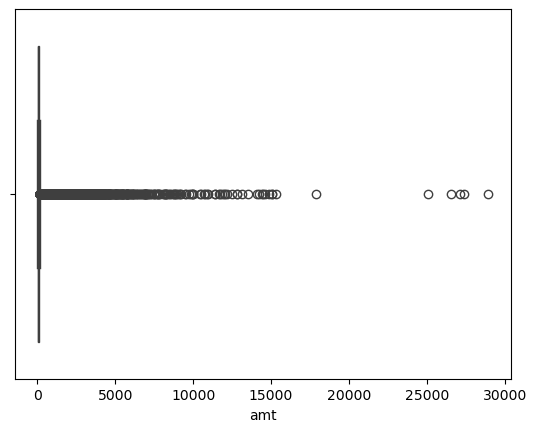

In [9]:
# def remove_outliers(dataframe, col_name, upper_limit):
#     """
#     Remove rows from the DataFrame where the values in the specified column exceed the upper_limit.

#     Outlier removal is crucial to reduce the impact of extreme values that might skew model training.
#     This function filters the DataFrame, keeping only those rows where the value in the given column
#     is below the provided upper_limit. If the specified column is not found, it prints a message and returns
#     the DataFrame unmodified.

#     Parameters:
#         dataframe (pd.DataFrame): The input DataFrame.
#         col_name (str): The name of the column to inspect for outliers.
#         upper_limit (float or int): The threshold value; rows with values equal to or above this will be removed.

#     Returns:
#         pd.DataFrame: The filtered DataFrame with outliers removed.
#     """
#     # Check if the specified column exists in the DataFrame.
#     if col_name not in dataframe.columns:
#         print(f"Column '{col_name}' not found. Skipping outlier removal.")
#         return dataframe

#     # Record the number of rows before removing outliers.
#     before = len(dataframe)
    
#     # Filter the DataFrame to keep rows where the column value is less than the upper limit.
#     dataframe = dataframe[dataframe[col_name] < upper_limit]
    
#     # Record the number of rows after filtering.
#     after = len(dataframe)
    
#     # Inform the user how many rows were removed.
#     print(f"Removed {before - after} outliers from '{col_name}'.")
    
#     return dataframe

# # Apply the outlier removal function to the DataFrame.
# df = remove_outliers(df, col_name="amt", upper_limit=15000)

# If I used the code above it would severly alter the boxplot below
# ____________________________________

sns.boxplot(x=df['amt'])
plt.show()

### Boxplot Interpretation

Based on the boxplot above it is evident that most of all of the transactions go up to around $15,000. It is also evident that there are transactions that above this threshold and would most definitely be the outliers within the dataset. Like I mentioned previously it is crucial that we do not remove any of the data points as any transaction could be fraudulent

# STEP 7: Encode Variables
Once the data has only the columns you want with all values filled out use frequency encoding and one hot encoding to change all textual variables to values that the machine learning model can understand (values).

In order for a binary classification model to work all of the columns within the dataset must be numerical. Considering that there are multiple textual columns within the dataset, to make sure that the machine learning model is able to run I need to convert them to numerical values. 

I chose to use frequency encoding for my dataset as there are tons of different values and this technique is most commonly used when there are a large number of individual value frequencies within the dataset.

In [10]:
def encode_categorical_features(dataframe, freq_threshold=10):
    """
    Encode categorical features in the DataFrame using two strategies:
    
    - One-hot encoding for categorical variables with a number of unique categories
      less than or equal to freq_threshold. One-hot encoding creates binary columns for each
      category (dropping the first to avoid multicollinearity).
    
    - Frequency encoding for categorical variables with more than freq_threshold unique categories.
      Frequency encoding replaces each category with its relative frequency in the column.
    
    This approach helps manage high-cardinality features while still providing useful representations
    for variables with fewer categories.
    """
    cat_cols = dataframe.select_dtypes(include=["object"]).columns
    freq_frames = {}

    for col in cat_cols:
        # Frequency encoding
        freq_map = dataframe[col].value_counts(normalize=True)
        freq_frames[col + "_freq"] = dataframe[col].map(freq_map)

    # Combine frequency-encoded columns
    if freq_frames:
        freq_df = pd.DataFrame(freq_frames, index=dataframe.index)
        dataframe = pd.concat([dataframe, freq_df], axis=1)

    # Drop original categorical columns
    dataframe.drop(columns=cat_cols, inplace=True)
    return dataframe

df = encode_categorical_features(df, freq_threshold=10)

print("values encoded!")

values encoded!


# STEP 8: Check Correlations
Establish a correlation matrix to establish which columns may have more positive or negative features to my target variab.e

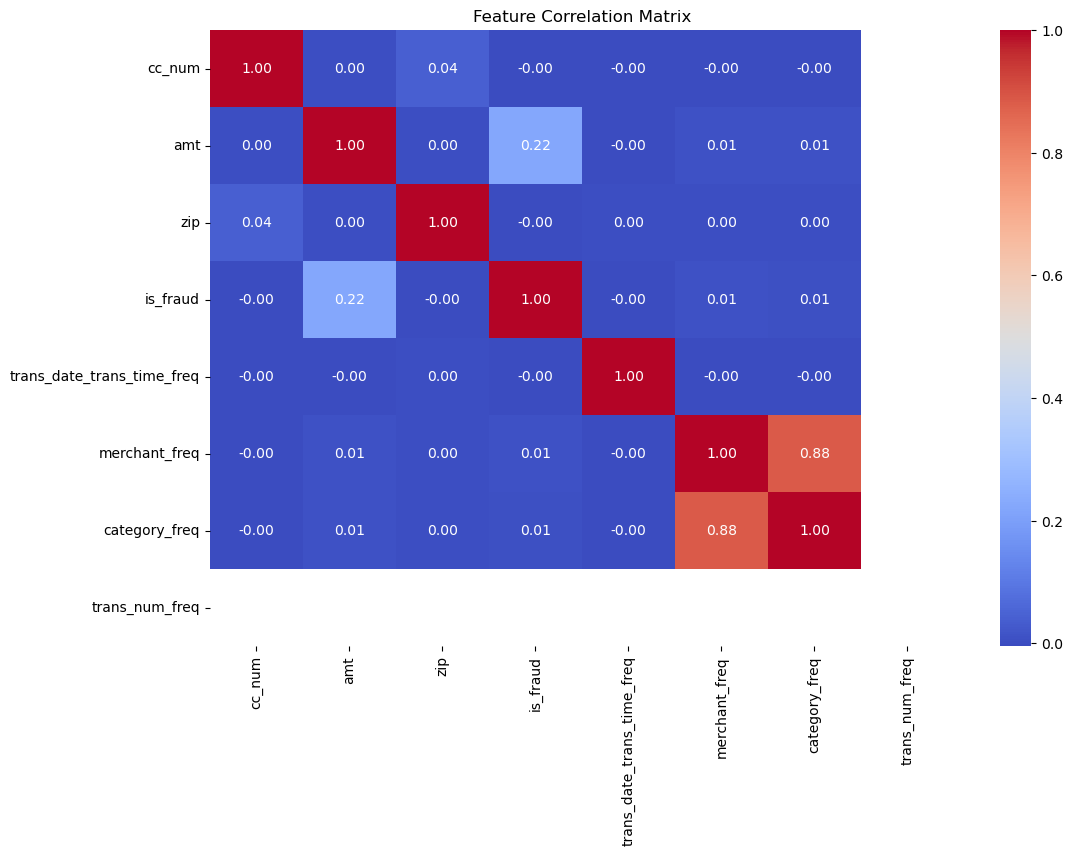

In [11]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

### Results:

After examining the correlation matrix it is evident to see that the strongest correlation to determine whether something is fraudulent or not. As expected it did make sense to me that the target variable was one of the most closely related features on this matrix (even though it is objectively not a strong correlation). It was also unsurprising to see that a there was a very strong correlation between the merchant and the merchant category as these two columns would describe the operations of one of the merchants that we looked at. Besides that, it was interesting to see a lack of relationship between the columns and that each column (for the most part) is linearly independant of the others.

# Step 9: Scale Features

Transform the data to be scaled to smaller values. This will ensure that the data cannot be biased due to a much smaller range of values. I chose to only scale the amount value due to this, this should help reduce the skew of the dataset without removing any of the outliers. This should help to improve the machine learning model that will be built on this dataset.

In [12]:
# Initialize standard scaler
scaler = StandardScaler()

# Scale 'amt' and 'trans_date_trans_time_freq' columns
df[['cc_num', 'amt', 'trans_date_trans_time_freq']] = scaler.fit_transform(df[['cc_num', 'amt', 'trans_date_trans_time_freq']])

print("Data Transformed")

Data Transformed


# Step 10: Final Display of the Data

In [13]:
print(df.head(5))
df.info()

     cc_num       amt    zip  is_fraud  trans_date_trans_time_freq  \
0 -0.316692 -0.407826  28654         0                   -0.184245   
1 -0.318757  0.230039  99160         0                   -0.184245   
2 -0.318728  0.934149  83252         0                   -0.184245   
3 -0.316058 -0.158132  59632         0                   -0.184245   
4 -0.318471 -0.177094  24433         0                   -0.184245   

   merchant_freq  category_freq  trans_num_freq  
0       0.000977       0.048807    7.712033e-07  
1       0.001930       0.095350    7.712033e-07  
2       0.001461       0.072504    7.712033e-07  
3       0.002015       0.101536    7.712033e-07  
4       0.001228       0.061430    7.712033e-07  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 8 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   cc_num                      1296675 non-null

# Step 11: Split the data into the training and testing sets

In order to make sure that the model is able to predict whether a transaction is fraudulent or not I needed to split up the data into testing and training data. As the dataset was so large (1.2 million entries) I needed to first, shrink the dataset to make sure that the model worked on a smaller dataset. Also, as fraudlent transactions are much less frequent than non fraudulent ones I needed to make sure that the training set had at least roughly 10% fraudulent transactions to make sure than the model knew the base case for fraudulent transactions. Once this was completed I was able to split it up into the training and testing sets. 

In [14]:
# Define sample sizes
fraud_samples = 2500
non_fraud_samples = 30000 - fraud_samples  # Ensure total size is 30,000

# Sample fraud and non-fraud cases separately
df_fraud = df[df["is_fraud"] == 1].sample(n=fraud_samples, random_state=42)
df_non_fraud = df[df["is_fraud"] == 0].sample(n=non_fraud_samples, random_state=42)

# Combine sampled data
df_sampled = pd.concat([df_fraud, df_non_fraud]).sample(frac=1, random_state=42)  # Shuffle

# Split features and target
X = df_sampled.drop("is_fraud", axis=1)
y = df_sampled["is_fraud"]

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

# Check class distribution
print("Training class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())


X_train: (24000, 7) y_train: (24000,)
X_val: (6000, 7) y_val: (6000,)
Training class distribution:
 0    22000
1     2000
Name: is_fraud, dtype: int64
Validation class distribution:
 0    5500
1     500
Name: is_fraud, dtype: int64


# STEP 12: Prepare files and set up Sagemaker Session

In this code I set up a folder path for the S3 bucket along with saving both the testing and training datasets for this code. I also then setup the Sagemaker Session for future training the model. 

In [15]:
# Initialize a SageMaker session
sagemaker_session = sagemaker.Session()

# Get IAM role associated with SageMaker
role = get_execution_role()

# Define S3 bucket, AWS region, and S3 folder prefix for storing data
bucket = sagemaker_session.default_bucket()  # Default S3 bucket assigned by SageMaker
region = sagemaker_session.boto_region_name  # AWS region of the session
prefix = "sagemaker/binary-cybersecurity"  # Folder path in S3

# Combine target labels (y) and feature data (X) for training and validation sets
train_data = pd.concat([y_train, X_train], axis=1)
validation_data = pd.concat([y_val, X_val], axis=1)

# Check for missing values and print a warning if found
if train_data.isnull().values.any() or validation_data.isnull().values.any():
    print("Warning: Missing values detected! Consider handling them before training.")

# Check for class imbalance and print a warning if any class dominates (>75% of the data)
train_class_distribution = y_train.value_counts(normalize=True)
val_class_distribution = y_val.value_counts(normalize=True)

if train_class_distribution.max() > 0.75 or val_class_distribution.max() > 0.75:
    print("Warning: Class imbalance detected. Consider balancing the dataset.")

# Define filenames for local storage
train_file = "cc_fraud_train.csv"
validation_file = "cc_fraud_test.csv"

# Save training and validation data to CSV files (no headers, no index)
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

# Upload datasets to Amazon S3 and retrieve their S3 locations
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

# Print the S3 paths of uploaded datasets for reference
print(f"Training data uploaded to: {train_uri}")
print(f"Validation data uploaded to: {validation_uri}")

[03/25/25 21:18:09] INFO     Found credentials from IAM Role:                                   ]8;id=294582;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=31126;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=842958;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=61843;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Training data uploaded to: s3://sagemaker-us-east-1-573921105544/sagemaker/binary-cybersecurity/cc_fraud_train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-573921105544/sagemaker/binary-cybersecurity/cc_fraud_test.csv


# STEP 13: Hyperparameter Tuning

In order to ensure the model is as accurate as possible I decided to use hyperparameter tuning in an attempt to increase the accuracy of the model. In order to make sure the model is as optimal as possible I decided to tune: mini-batch-size, learning-rate, wd, l1, positive_example_weight_mult and use_bias. These are all of the possible tunable parameters for a binary classifcation model.


In [17]:
from sagemaker.tuner import (
    HyperparameterTuner,
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter
)

# Create TrainingInput objects for tuning
train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# Retrieve the container image URI for the Linear Learner algorithm in the specified region.
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

# Determine the number of features (ensure this is defined using your dataset).
num_features = X.shape[1]

# Instantiate the SageMaker Estimator for the Linear Learner model.
linear_learner = Estimator(
    image_uri=container,                        # The container image for Linear Learner.
    role=role,                                  # IAM role with necessary permissions.
    instance_count=1,                           # Number of instances.
    instance_type='ml.m5.large',                # Instance type based on resource needs.
    output_path=f's3://{bucket}/{prefix}/output',# S3 bucket & prefix for model artifacts.
    sagemaker_session=sagemaker_session         # Active SageMaker session.
)

# Set base hyperparameters for the Linear Learner.
linear_learner.set_hyperparameters(
    feature_dim=num_features,
    predictor_type='binary_classifier'
)

# -------------------------------
# Hyperparameter Tuning Section
# -------------------------------

# Define hyperparameter ranges to tune.
hyperparameter_ranges = {
    'mini_batch_size': IntegerParameter(16, 128),
    'learning_rate': ContinuousParameter(0.0001, 0.1), 
    'wd': ContinuousParameter(0.0001, 0.1), 
    'l1': ContinuousParameter(0.0001, 0.1),
    'positive_example_weight_mult': ContinuousParameter(0.5, 10.0),
    'use_bias': CategoricalParameter(['true', 'false'])
}

# Specify the objective metric.
objective_metric_name = "validation:binary_classification_accuracy"
objective_type = "Maximize"

# Create the Hyperparameter Tuner.
tuner = HyperparameterTuner(
    estimator=linear_learner,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,
    max_jobs=10,            # Total number of training jobs to be run.
    max_parallel_jobs=2,     # How many training jobs run in parallel.
)

# Create TrainingInput objects for tuning.
train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# Launch the hyperparameter tuning job.
tuner.fit({'train': train_input, 'validation': validation_input})
print("Hyperparameter tuning job launched!")


[03/25/25 21:21:16] INFO     Same images used for training and inference. Defaulting to image     ]8;id=264243;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=544715;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=966110;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=772835;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

[03/25/25 21:21:17] WARNING  No finished training job found associated with this estimator.       ]8;id=9344;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=779040;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=198280;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=568220;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=495323;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=63394;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             linear-learner-250325-2121                                                            

.............................................................................................................................................!
Hyperparameter tuning job launched!


# STEP 14: Hyperparameter Tuning

Initializing a Sagemaker Session with the new tuned endpoint allowing me to query the new model and test it thoroughly.

In [26]:
# -----------------------------------------------------------------------------
# Initialize session and SageMaker client.
# -----------------------------------------------------------------------------
session = Session()  # High-level SageMaker session
sm_client = boto3.client("sagemaker")

# Define a new endpoint name for the tuned model.
endpoint_name = "binary-endpoint-tuned"

# -----------------------------------------------------------------------------
# 1. Built-in waiter for InService (helps waiting on creation)
# -----------------------------------------------------------------------------
endpoint_in_service_waiter = sm_client.get_waiter("endpoint_in_service")

def delete_endpoint_and_config(endpoint_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes an endpoint and its corresponding endpoint configuration (if they exist).
    Optionally polls until resources are deleted.
    """
    # 1. Delete endpoint (if it exists).
    try:
        endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_status = endpoint_desc["EndpointStatus"]

        # If the endpoint is Creating or Updating, wait until it becomes InService.
        if endpoint_status in ("Creating", "Updating"):
            logger.info(f"Endpoint '{endpoint_name}' is in '{endpoint_status}' state. Waiting before deletion.")
            endpoint_in_service_waiter.wait(EndpointName=endpoint_name)
        
        logger.info(f"Deleting endpoint: {endpoint_name}")
        sm_client.delete_endpoint(EndpointName=endpoint_name)

    except ClientError as e:
        if e.response["Error"]["Code"] == "ValidationException" and "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Endpoint '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # 2. Delete endpoint configuration (if it exists).
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleting endpoint configuration: {endpoint_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    except ClientError as e:
        if e.response["Error"]["Code"] == "ValidationException" and "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Endpoint config '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e

    # 3. Optionally poll for deletion.
    if wait_for_deletion:
        logger.info("Waiting for endpoint & configuration to be deleted...")
        for _ in range(30):
            endpoint_exists = True
            endpoint_config_exists = True

            try:
                sm_client.describe_endpoint(EndpointName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_exists = False

            try:
                sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_config_exists = False

            if not endpoint_exists and not endpoint_config_exists:
                logger.info("Endpoint and endpoint config fully deleted.")
                break

            logger.info("Endpoint or endpoint config still deleting... sleeping 10s.")
            time.sleep(10)
        else:
            logger.warning("Endpoint or endpoint config not fully deleted after 30 checks.")

def delete_model(model_name: str, wait_for_deletion: bool = True) -> None:
    """
    Deletes a SageMaker model if it exists. Optionally waits until it disappears.
    """
    try:
        sm_client.describe_model(ModelName=model_name)
        logger.info(f"Deleting model: {model_name}")
        sm_client.delete_model(ModelName=model_name)
    except ClientError as e:
        if "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Model '{model_name}' does not exist or is already deleted.")
        else:
            raise e

    if wait_for_deletion:
        for _ in range(20):
            try:
                sm_client.describe_model(ModelName=model_name)
                logger.info("Model still deleting... sleeping 5s.")
                time.sleep(5)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    logger.info("Model fully deleted.")
                    break
        else:
            logger.warning("Model was not deleted after waiting.")

# -----------------------------------------------------------------------------
# Delete any existing endpoint and configuration with the same name.
# -----------------------------------------------------------------------------
delete_endpoint_and_config(endpoint_name)

# -----------------------------------------------------------------------------
# Retrieve the best estimator from the completed tuning job.
# -----------------------------------------------------------------------------
best_estimator = tuner.best_estimator()  # Assumes that 'tuner' is defined and tuning is complete

# -----------------------------------------------------------------------------
# Deploy the best model.
# -----------------------------------------------------------------------------
predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

# Set the serializer and deserializer for the predictor.
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

logger.info(f"Best model deployed to endpoint: {endpoint_name} and ready for inference.")


[03/25/25 22:39:09] INFO     Endpoint 'binary-endpoint-tuned' does not exist or has already been   ]8;id=630178;file:///tmp/ipykernel_7504/3171786439.py\3171786439.py]8;;\:]8;id=761421;file:///tmp/ipykernel_7504/3171786439.py#35\35]8;;\
                             deleted.                                                                              

                    INFO     Endpoint config 'binary-endpoint-tuned' does not exist or has already ]8;id=770384;file:///tmp/ipykernel_7504/3171786439.py\3171786439.py]8;;\:]8;id=570704;file:///tmp/ipykernel_7504/3171786439.py#46\46]8;;\
                             been deleted.                                                                         

                    INFO     Waiting for endpoint & configuration to be deleted...                 ]8;id=165184;file:///tmp/ipykernel_7504/3171786439.py\3171786439.py]8;;\:]8;id=10355;file:///tmp/ipykernel_7504/3171786439.py#52\52]8;;\

[03/25/25 22:39:10] INFO     Endpoint and endpoint config fully deleted.                           ]8;id=112895;file:///tmp/ipykernel_7504/3171786439.py\3171786439.py]8;;\:]8;id=76849;file:///tmp/ipykernel_7504/3171786439.py#70\70]8;;\


2025-03-25 21:33:17 Starting - Found matching resource for reuse
2025-03-25 21:33:17 Downloading - Downloading the training image
2025-03-25 21:33:17 Training - Training image download completed. Training in progress.
2025-03-25 21:33:17 Uploading - Uploading generated training model
2025-03-25 21:33:17 Completed - Resource released due to keep alive period expiry


[03/25/25 22:39:15] INFO     Creating model with name: linear-learner-2025-03-25-22-39-15-459       ]8;id=101100;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=708515;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/25/25 22:39:16] INFO     Creating endpoint-config with name binary-endpoint-tuned               ]8;id=841623;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=185104;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name binary-endpoint-tuned                      ]8;id=162101;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=940952;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

----------!

[03/25/25 22:44:47] INFO     Best model deployed to endpoint: binary-endpoint-tuned and ready for ]8;id=137396;file:///tmp/ipykernel_7504/3171786439.py\3171786439.py]8;;\:]8;id=761530;file:///tmp/ipykernel_7504/3171786439.py#128\128]8;;\
                             inference.                                                                            

# STEP 15: Evaluating the Model
# A) Confusion Matrix

In order to test the model and analyze what it does excellently versus where the model lacks I calculate the accuracy, precision and recall. The overall accuracy of the model was a staggering 96.33% which is the total correct predictions of all of the tests. I do want to mention that as the dataset is imbalanced this may play a role in why the accuracy is so high. Next I analyzed the precision which was 79.79% which is still extremely high as this means that for all of positives it got almost 80% of them correct. After that I analyzed the recall of the model which ended up being 75%. This is an ok recall as these are the actual positive cases, but more importantly this indicates that there are a lot of false negatives which means that the model is explaining that the model is flagging more cases that are not fraud which is much better than the opposite.


 **Evaluation Metrics:**
  Accuracy:  0.9633
  Precision: 0.7979
  Recall:    0.7500
  F1 Score:  0.7732

**Classification Report:**
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5500
           1       0.80      0.75      0.77       500

    accuracy                           0.96      6000
   macro avg       0.89      0.87      0.88      6000
weighted avg       0.96      0.96      0.96      6000


**Confusion Matrix (Raw Values):**
[[5405   95]
 [ 125  375]]


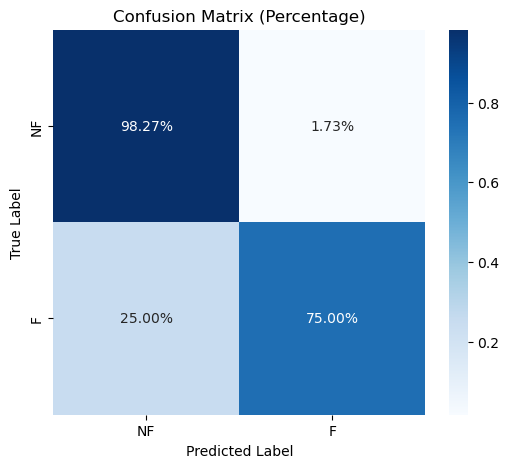

{'Accuracy': 0.9633333333333334, 'Precision': 0.7978723404255319, 'Recall': 0.75, 'F1 Score': 0.7731958762886598}


In [33]:
def evaluate_deployed_classifier(predictor, X_val, y_val):
    """
    Evaluate the deployed classification model on the test set.

    Fixes:
      - Extracts only 'predicted_label'.
      - Limits printed output for readability.
      - Handles unexpected response formats safely.

    Parameters:
      predictor: SageMaker Predictor object for the deployed model.
      X_val (pd.DataFrame): Test features.
      y_val (pd.Series): True labels.

    Returns:
      dict: Evaluation metrics (Accuracy, Precision, Recall, F1 Score)
    """

    # Ensure the predictor uses the correct serialization
    predictor.serializer = CSVSerializer()

    # Copy test features and labels
    X_test = X_val.copy()
    y_test = y_val.copy()

    # Get predictions from the deployed endpoint
    predictions = predictor.predict(X_test.values)

    # Ensure correct extraction of predicted labels
    try:
        predicted_labels = [int(result["predicted_label"]) for result in predictions["predictions"]]
    except (KeyError, TypeError) as e:
        print(f"Error extracting predictions: {e}")
        return None  # Stop execution if predictions are not correctly formatted

    # Compute evaluation metrics
    acc = accuracy_score(y_test, predicted_labels)
    prec = precision_score(y_test, predicted_labels, zero_division=0)
    rec = recall_score(y_test, predicted_labels, zero_division=0)
    f1 = f1_score(y_test, predicted_labels, zero_division=0)

    # Print evaluation metrics
    print("\n **Evaluation Metrics:**")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}\n")

    # Print detailed classification report
    print("**Classification Report:**")
    print(classification_report(y_test, predicted_labels))

    # Compute and visualize the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    print("\n**Confusion Matrix (Raw Values):**")
    print(cm)

    # Confusion Matrix with percentages for better readability
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize per class
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues",
                xticklabels=["NF", "F"],
                yticklabels=["NF", "F"])
    plt.title("Confusion Matrix (Percentage)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Return computed evaluation metrics
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

# Example call:
# Replace 'predictor', 'X_val', and 'y_val' with actual objects
metrics = evaluate_deployed_classifier(predictor, X_val, y_val)
print(metrics)


# B) Test the first five rows

In [34]:
"""
Module: Model Prediction and Evaluation for Binary Classification using SageMaker Predictor

This module shows how to obtain predictions from a deployed SageMaker predictor for a binary classification task.
It selects the first 5 rows from the test set, sends them to the endpoint in CSV format,
extracts the predicted probabilities, converts them to binary labels using a threshold, and compares the predictions
with the actual target values.
"""

# Select the first 5 rows from the test set for evaluation.
sample_data = X_val.head(5)

# Convert the selected data to a NumPy array.
# This format is required by the predictor's CSVSerializer.
input_data = sample_data.values

# Request predictions from the deployed endpoint using the sample data.
predictions = predictor.predict(input_data)

# Process the response if it contains the 'predictions' key.
if "predictions" in predictions:
    # Extract the predicted probabilities from each result.
    y_pred_test_probs = [float(result["score"]) for result in predictions["predictions"]]
    
    # Define a threshold to convert probabilities into binary class labels.
    threshold = 0.5
    # Convert probabilities to binary labels: 1 if above the threshold, else 0.
    y_pred_test_classes = [1 if prob > threshold else 0 for prob in y_pred_test_probs]
    
    print("\nTest Probabilities on 5 samples:", y_pred_test_probs)
    print("Test Predicted Classes on 5 samples:", y_pred_test_classes)
else:
    print("No 'predictions' key found in the response:", predictions)

# Retrieve the actual target values for the selected sample data.
sample_targets = y_val.loc[sample_data.index]
print("Actual:", sample_targets.tolist())



Test Probabilities on 5 samples: [0.018543362617492676, 0.031032759696245193, 0.0314679816365242, 0.04325011372566223, 0.02398781105875969]
Test Predicted Classes on 5 samples: [0, 0, 0, 0, 0]
Actual: [0, 0, 0, 0, 0]


# Step 16: Delete the endpoint

In [35]:
"""
Module: SageMaker Endpoint and Configuration Deletion

This module defines a function to delete a SageMaker endpoint and its corresponding endpoint configuration.
It first attempts to describe each resource to verify its existence, then deletes it if found.
If a resource is not found, it prints a message indicating so and continues without raising an error.
"""

def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    """
    Delete a SageMaker endpoint and its configuration if they exist.

    Parameters:
        sm_client: Boto3 client for SageMaker.
        endpoint_name (str): The name of the endpoint to delete.
        endpoint_config_name (str): The name of the endpoint configuration to delete.
    """
    # Delete the endpoint.
    try:
        # Attempt to describe the endpoint to check if it exists.
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        # If no exception, proceed to delete the endpoint.
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        # If the endpoint is not found, inform the user and continue.
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e

    # Delete the endpoint configuration.
    try:
        # Attempt to describe the endpoint configuration to check if it exists.
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        # If no exception, proceed to delete the endpoint configuration.
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        # If the endpoint configuration is not found, inform the user and continue.
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Automatically delete the endpoint and its configuration.
delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name="binary-endpoint-tuned")


Deleted endpoint: binary-endpoint-tuned
Deleted endpoint config: binary-endpoint-tuned
